In [15]:
# ==================================================================================================
# --- Imports
# ==================================================================================================
import logging
import time

import pandas as pd
import tree_maker
import yaml

# ==================================================================================================
# --- Load tree of jobs
# ==================================================================================================

# Start of the script
print("Analysis of output simulation files started")
start = time.time()

# Load Data
study_name = "tune_scan_30cm_debug8"
fix = "/scans/" + study_name
root = tree_maker.tree_from_json(fix[1:] + "/tree_maker.json")
# Add suffix to the root node path to handle scans that are not in the root directory
root.add_suffix(suffix=fix)


# ==================================================================================================
# --- # Browse simulations folder and extract relevant observables
# ==================================================================================================
l_problematic_sim = []
l_df_to_merge = []
for node in root.generation(1):
    with open(f"{node.get_abs_path()}/config.yaml", "r") as fid:
        config_parent = yaml.safe_load(fid)
    for node_child in node.children:
        with open(f"{node_child.get_abs_path()}/config.yaml", "r") as fid:
            config_child = yaml.safe_load(fid)

        try:
            # Read the particle path as relative
            try:
                particle = pd.read_parquet(
                    f"{node_child.get_abs_path()}/{config_child['config_simulation']['particle_file']}"
                )

            # If it doesn't work, try to read it as absolute
            except:
                particle = pd.read_parquet(f"{config_child['config_simulation']['particle_file']}")

            df_sim = pd.read_parquet(f"{node_child.get_abs_path()}/output_particles.parquet")

        except Exception as e:
            print(e)
            l_problematic_sim.append(node_child.get_abs_path())
            continue

        # Register paths and names of the nodes
        df_sim["path base collider"] = f"{node.get_abs_path()}"
        df_sim["name base collider"] = f"{node.name}"
        df_sim["path simulation"] = f"{node_child.get_abs_path()}"
        df_sim["name simulation"] = f"{node_child.name}"

        # Get node parameters as dictionnaries for parameter assignation
        dic_child_collider = node_child.parameters["config_collider"]
        dic_child_simulation = node_child.parameters["config_simulation"]
        try:
            dic_parent_collider = node.parameters["config_mad"]
        except:
            print("No parent collider could be loaded")
        dic_parent_particles = node.parameters["config_particles"]

        # Get which beam is being tracked
        df_sim["beam"] = dic_child_simulation["beam"]

        # Get scanned parameters (complete with the requested scanned parameters)
        df_sim["qx"] = dic_child_collider["config_knobs_and_tuning"]["qx"]["lhcb1"]
        df_sim["qy"] = dic_child_collider["config_knobs_and_tuning"]["qy"]["lhcb1"]
        df_sim["dqx"] = dic_child_collider["config_knobs_and_tuning"]["dqx"]["lhcb1"]
        df_sim["dqy"] = dic_child_collider["config_knobs_and_tuning"]["dqy"]["lhcb1"]
        df_sim["i_bunch_b1"] = dic_child_collider["config_beambeam"]["mask_with_filling_pattern"][
            "i_bunch_b1"
        ]
        df_sim["i_bunch_b2"] = dic_child_collider["config_beambeam"]["mask_with_filling_pattern"][
            "i_bunch_b2"
        ]
        df_sim["num_particles_per_bunch"] = dic_child_collider["config_beambeam"][
            "num_particles_per_bunch"
        ]
        df_sim["i_oct_b1"] = dic_child_collider["config_knobs_and_tuning"]["knob_settings"][
            "i_oct_b1"
        ]
        df_sim["i_oct_b2"] = dic_child_collider["config_knobs_and_tuning"]["knob_settings"][
            "i_oct_b2"
        ]
        df_sim["crossing_angle"] = abs(
            float(dic_child_collider["config_knobs_and_tuning"]["knob_settings"]["on_x1"])
        )

        # Merge with particle data
        df_sim_with_particle = pd.merge(df_sim, particle, on=["particle_id"])
        l_df_to_merge.append(df_sim_with_particle)

# ==================================================================================================
# --- # Merge all jobs outputs in one dataframe and save it
# ==================================================================================================

# Merge the dataframes from all simulations together
df_all_sim = pd.concat(l_df_to_merge)

Analysis of output simulation files started


In [31]:
# Extract the particles that were lost for DA computation
df_lost_particles = df_all_sim[df_all_sim["state"] != 1]  # Lost particles

# Check if the dataframe is empty
if df_lost_particles.empty:
    print("No unstable particles found, the output dataframe will be empty.")

# Group by working point (Update this with the knobs you want to group by !)
group_by_parameters = ["name base collider", "qx", "qy"]
# group_by_parameters = ["name base collider"]

# We always want to keep beam in the final result
group_by_parameters = ["beam"] + group_by_parameters
l_parameters_to_keep = [
    "particle_id",
    "normalized amplitude in xy-plane",
    "angle in xy-plane [deg]",
    "qx",
    "qy",
    "dqx",
    "dqy",
    "i_bunch_b1",
    "i_bunch_b2",
    "num_particles_per_bunch",
    "crossing_angle",
]

# Min is computed in the groupby function, but values should be identical
my_final = pd.DataFrame(
    [
        df_lost_particles.groupby(group_by_parameters)[parameter].min()
        for parameter in l_parameters_to_keep
    ]
).transpose()

In [29]:
particle

,particle_id,normalized amplitude in xy-plane,angle in xy-plane [deg]
0,1275.0,9.84375,75.0
1,1276.0,9.87500,75.0
2,1277.0,9.90625,75.0
3,1278.0,9.93750,75.0
4,1279.0,9.96875,75.0


In [17]:
my_final

,,,,normalized amplitude in xy-plane,angle in xy-plane [deg],qx,qy,dqx,dqy,i_bunch_b1,i_bunch_b2,num_particles_per_bunch,crossing_angle
beam,name base collider,qx,qy,,,,,,,,,,
lhcb1,base_collider,62.31,60.316,2.0,15.0,62.31,60.316,15.0,15.0,978.0,975.0,1.150000e+11,160.0


In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_all_sim[["particle_id", 'normalized amplitude in xy-plane', 'state']])


   particle_id  normalized amplitude in xy-plane  state
0          0.0                           2.00000      1
1          1.0                           2.03125      1
2          2.0                           2.06250      1
3          3.0                           2.09375      1
4          4.0                           2.12500      1
5          5.0                           2.15625      1
0          6.0                           2.18750      1
1          7.0                           2.21875      1
2          8.0                           2.25000      1
3          9.0                           2.28125      1
4         10.0                           2.31250      1
5         11.0                           2.34375      1
0         12.0                           2.37500      1
1         13.0                           2.40625      1
2         14.0                           2.43750      1
3         15.0                           2.46875      1
4         16.0                           2.50000

In [20]:
import matplotlib.pyplot as plt
import numpy as np

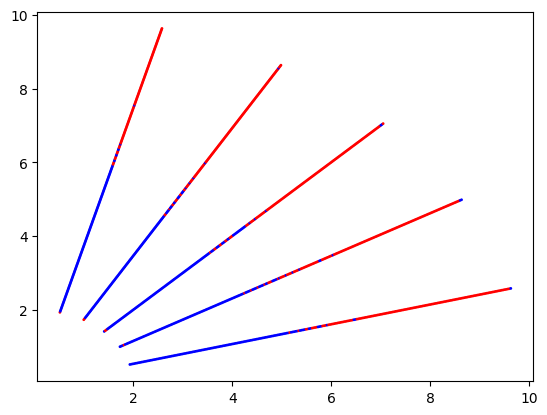

In [25]:
plt.scatter(df_all_sim['normalized amplitude in xy-plane'] * np.cos(df_all_sim["angle in xy-plane [deg]"]/180*np.pi),
         df_all_sim['normalized amplitude in xy-plane'] * np.sin(df_all_sim["angle in xy-plane [deg]"]/180*np.pi),
         c = ['red' if x==-1 else 'blue' for x in df_all_sim['state']], s = 1)
plt.show()

In [19]:
df_all_sim.columns

Index(['start_tracking_at_element', 'q0', 'mass0', 's', 'zeta', 'chi',
       'charge_ratio', 'weight', 'pdg_id', 'particle_id', 'at_element',
       'at_turn', 'state', 'parent_particle_id', '_rng_s1', '_rng_s2',
       '_rng_s3', '_rng_s4', 'x', 'y', 'px', 'py', 'delta', 'ptau', 'rvv',
       'rpp', 'p0c', 'beta0', 'gamma0', 'path base collider',
       'name base collider', 'path simulation', 'name simulation', 'beam',
       'qx', 'qy', 'dqx', 'dqy', 'i_bunch_b1', 'i_bunch_b2',
       'num_particles_per_bunch', 'i_oct_b1', 'i_oct_b2', 'crossing_angle',
       'normalized amplitude in xy-plane', 'angle in xy-plane [deg]'],
      dtype='object')